Make sure you write dimesnions using writeDimensions(nx, ny)
2 0.1 40 4


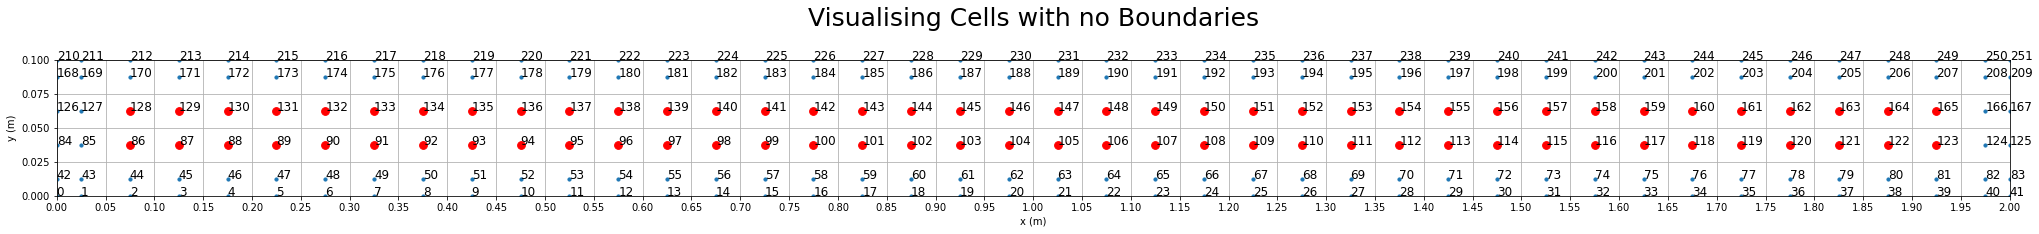

/home/scottlevie/newPythonSolver/python_fv_csm/seperate_notebooks/Background_Functions.ipynb:350: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  "        \n",


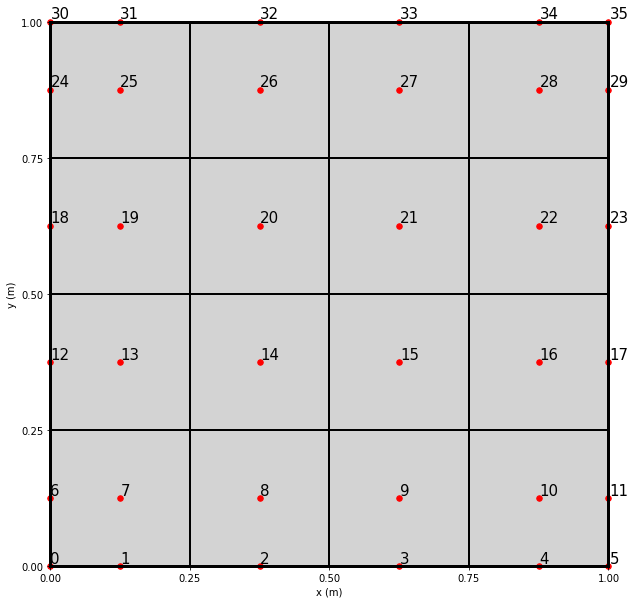

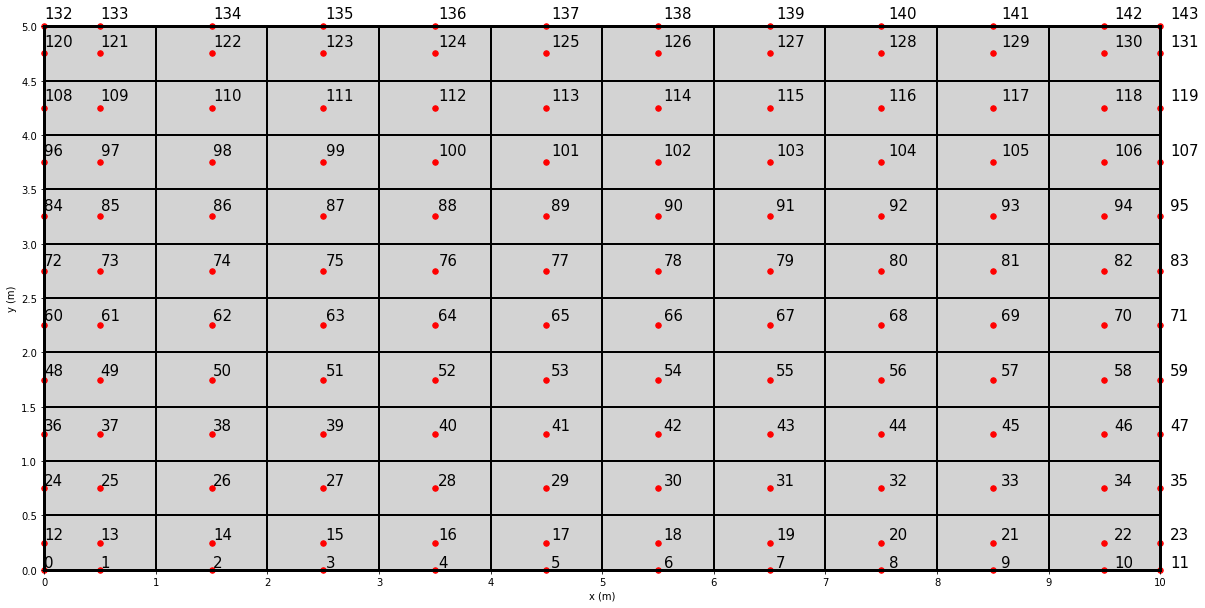

(144, 2)
Number of nodes in Mesh: 144
Number of dimensions: 2
Shear Modulus (mu): 76923076923.07692
Lame Modulus (_lambda): 115384615384.61539
Printing example a-term values for fixed displacement cell on the top boundary:

a_N should be twice the size of a_S
a_E and a_W should be identical

Value for a_N:  307692307692.3077
Value for a_S:  153846153846.15384
Value for a_E:  134615384615.38461
Value for a_W:  134615384615.38461
Value for a_P:  730769230769.2308
Printing a-term values for fixed traction cell on the top boundary:

a_N should 0
a_E and a_W should be identical

Value for a_N:  0
Value for a_S:  153846153846.15384
Value for a_E:  134615384615.38461
Value for a_W:  134615384615.38461
Value for a_P:  423076923076.9231


In [1]:
from ipynb.fs.full.Background_Functions import *
from ipynb.fs.full._05_Fixed_Traction_BCs import *

# Ignore outputs from this cell

# Solution Algorithm

---


Now that we've described and coded the $A$-matrices and $b$-matrices for: all points within the mesh, and both the x and y momentum equations. We now need to discuss how these matrices will be solved.

## **Step 1:** Initialise Matrix

We'll create both the A and b matrices for the x and y equations


### Creating the $A$ matrix

Previously we have created the A matrix for internal cells. This is as follows:


In [2]:
# x A matrix
A_x = A("x").createMatrix()

# y A matrix
A_y = A("y").createMatrix()


### Add boundary condition terms to $A$ and $b$ matrices


So far for each point and cell on boundaries we've created functions that take in A and b matrices and assign the a-terms and b-terms to these matrices. Now we need to write a function that loops through each point <code>k</code> in the mesh and assign the correct term.

For each point/cell we need to determine if the what type of BC is applied. <code>cell_corner_BCs</code> already looks up what BC is applied so we only need to write functions for the boundary cells and points:


For Cells:


In [3]:
def cell_boundary_selection(
    A_matrix, b_matrix, k, boundaries, xy, U_old, U_old_old, U_previous
):

    if BC_settings(boundaries[0]).traction:
        A_matrix, b_matrix = traction_cell_BCs(
            A_matrix, b_matrix, k, boundaries, xy, U_old, U_old_old, U_previous
        )

    elif BC_settings(boundaries[0]).fixed_displacement:
        A_matrix, b_matrix = displacement_cell_BCs(
            A_matrix, b_matrix, k, boundaries, xy, U_old, U_old_old, U_previous
        )

    return A_matrix, b_matrix


For Points:


In [4]:
def point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous):

    if BC_settings(boundaries[0]).traction:
        A_matrix, b_matrix = traction_point_BCs(
            A_matrix, b_matrix, k, boundaries, xy, U_previous
        )

    elif BC_settings(boundaries[0]).fixed_displacement:
        A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries, xy)

    return A_matrix, b_matrix


For we can loop through each point <code>k</code>, determine if it is a boundary point, cell or corner, and apply the BC terms. This function is long but it is simple once you go through it.

In [5]:
def boundary_conditions(A_matrix, b_matrix, U_previous, u_old, u_old_old, xy):
    for k in np.arange(0,(nx+2)*(ny+2)):   # j is the cell number

        # This value is assigned to either side of the corner approximation function to aid convergence
        fac = 1
        # fac = 100000000

       #Bottom left corner coefficients        
        if cell_index().bottom_left_corner(k):  

            boundaries = ["b", "l"]
            
            A_matrix, b_matrix = cell_corner_BCs(A_matrix, b_matrix, k, boundaries, xy, U_previous, u_old, u_old_old)          

        #Bottom right corner coefficients            
        elif  cell_index().bottom_right_corner(k):
            boundaries = ["b", "r"]
            
            A_matrix, b_matrix = cell_corner_BCs(A_matrix, b_matrix, k, boundaries, xy, U_previous, u_old, u_old_old)

        #Top left corner coefficients            
        elif  cell_index().top_left_corner(k):
            boundaries = ["t", "l"]
        
            A_matrix, b_matrix = cell_corner_BCs(A_matrix, b_matrix, k, boundaries, xy, U_previous, u_old, u_old_old)

        #Top right corner coefficients            
        elif  cell_index().top_right_corner(k):  
            boundaries = ["t", "r"]
            
            A_matrix, b_matrix = cell_corner_BCs(A_matrix, b_matrix, k, boundaries, xy, U_previous, u_old, u_old_old)

        # Center Bottom Boundaries
        elif  cell_index().center_bottom(k):
            boundaries = ["b"]

            A_matrix, b_matrix = cell_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, u_old, u_old_old, U_previous)

        # Center Top Boundaries
        elif cell_index().center_top(k):
            boundaries = ["t"]

            A_matrix, b_matrix = cell_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, u_old, u_old_old, U_previous)

        # Center Left Boundaries
        elif  cell_index().center_left(k):
            boundaries = ["l"]

            A_matrix, b_matrix = cell_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, u_old, u_old_old, U_previous)

        # Center Right Boundaries
        elif  cell_index().center_right(k):
            boundaries = ["r"]

            A_matrix, b_matrix = cell_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, u_old, u_old_old, U_previous)

        #### Points on Boundary ####

        # Center Bottom
        elif boundary_point_index().center_bottom(k):
            boundaries = ["b"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

        # Center Top
        elif boundary_point_index().center_top(k):
            boundaries = ["t"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

            
        # Center Left
        elif boundary_point_index().center_left(k):
            boundaries = ["l"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)


        # Center Right
        elif boundary_point_index().center_right(k):
            boundaries = ["r"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)


        # Bottom Left: Bottom
        elif boundary_point_index().bottom_left_bottom(k):
            boundaries = ["b", "l"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)


        # Bottom Left: Left
        elif boundary_point_index().bottom_left_left(k):
            boundaries = ["l", "b"]
            
            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

            
        # Bottom Right: Right
        elif boundary_point_index().bottom_right_right(k):
            boundaries = ["r", "b"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

        # Bottom Right: Bottom
        elif boundary_point_index().bottom_right_bottom(k):
            boundaries = ["b", "r"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

        # Top Left: Left
        elif boundary_point_index().top_left_left(k):
            boundaries = ["l", "t"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)


        # Top Left: Top
        elif boundary_point_index().top_left_top(k):
            boundaries = ["t", "l"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

        # Top Right: Right
        elif boundary_point_index().top_right_right(k):
            boundaries = ["r", "t"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

        # Top Right: Top        
        elif boundary_point_index().top_right_top(k):
            boundaries = ["t", "r"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

        # # Corner Points

        # If one of the boundaries uses fixed displacement this BC is used, if both boundaries use traction an interpolation is used

        elif boundary_point_index().bottom_left_corner(k):

            boundaries = ["b", "l"]
                    
            if BC_settings(boundaries[0]).fixed_displacement & BC_settings(boundaries[1]).traction:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[0], xy)

            elif BC_settings(boundaries[0]).traction & BC_settings(boundaries[1]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[1], xy)

            else: 
                A_matrix[k,k] = 4*fac

                A_matrix[k,index(k).n] = 2*fac
                A_matrix[k,index(k).e] = 2*fac

                A_matrix[k,index(k).ne] = -15*fac

                A_matrix[k,index(k).dir(["n", "n"])] = 2*fac 
                A_matrix[k,index(k).dir(["e", "e"])] = 2*fac

                A_matrix[k,index(k).dir(["n", "ne"])] = 1*fac
                A_matrix[k,index(k).dir(["ne", "ne"])] = 1*fac
                A_matrix[k,index(k).dir(["e", "ne"])] = 1*fac

                b_matrix[k] = 0

        elif boundary_point_index().bottom_right_corner(k):
            boundaries = ["b", "r"]
            
            if BC_settings(boundaries[0]).fixed_displacement & BC_settings(boundaries[1]).traction:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[0], xy)

            elif BC_settings(boundaries[0]).traction & BC_settings(boundaries[1]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[1], xy)

            else: 
                A_matrix[k,k] = 4*fac

                A_matrix[k,index(k).n] = 2 *fac
                A_matrix[k,index(k).w] = 2*fac

                A_matrix[k,index(k).nw] = -15*fac

                A_matrix[k,index(k).dir(["n", "n"])] = 2 *fac
                A_matrix[k,index(k).dir(["w", "w"])] = 2*fac

                A_matrix[k,index(k).dir(["n", "nw"])] = 1*fac
                A_matrix[k,index(k).dir(["nw", "nw"])] = 1*fac
                A_matrix[k,index(k).dir(["w", "nw"])] = 1*fac

                b_matrix[k] = 0

        elif boundary_point_index().top_left_corner(k):

            boundaries = ["t", "l"]
            
            if BC_settings(boundaries[0]).fixed_displacement & BC_settings(boundaries[1]).traction:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[0], xy)

            elif BC_settings(boundaries[0]).traction & BC_settings(boundaries[1]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[1], xy)

            else: 
                A_matrix[k,k] = 4*fac

                A_matrix[k,index(k).s] = 2 *fac
                A_matrix[k,index(k).e] = 2*fac

                A_matrix[k,index(k).se] = -15*fac

                A_matrix[k,index(k).dir(["s", "s"])] = 2 *fac
                A_matrix[k,index(k).dir(["e", "e"])] = 2*fac

                A_matrix[k,index(k).dir(["s", "se"])] = 1*fac
                A_matrix[k,index(k).dir(["se", "se"])] = 1*fac
                A_matrix[k,index(k).dir(["e", "se"])] = 1*fac

                b_matrix[k] = 0

        elif boundary_point_index().top_right_corner(k):

            boundaries = ["t", "r"]
            
            if BC_settings(boundaries[0]).fixed_displacement & BC_settings(boundaries[1]).traction:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[0], xy)

            elif BC_settings(boundaries[0]).traction & BC_settings(boundaries[1]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[1], xy)

            else: 

                A_matrix[k,k] = 4*fac

                A_matrix[k,index(k).s] = 2 *fac
                A_matrix[k,index(k).w] = 2*fac

                A_matrix[k,index(k).sw] = -15*fac

                A_matrix[k,index(k).dir(["s", "s"])] = 2 *fac
                A_matrix[k,index(k).dir(["w", "w"])] = 2*fac

                A_matrix[k,index(k).dir(["s", "sw"])] = 1*fac
                A_matrix[k,index(k).dir(["sw", "sw"])] = 1*fac
                A_matrix[k,index(k).dir(["w", "sw"])] = 1*fac

                b_matrix[k] = 0      

        else:

            b_matrix[k] = (
                            A.b_temp(u_old, u_old_old, k, xy)
                            +
                            A.b_force(k, xy, U_previous)
                        )

    return A_matrix, b_matrix


Using this function to assign BC values to A and b matrices: 

In [6]:
# Initialise b-matrix 
b_x = np.zeros([(ny+2)*(nx+2),1])
b_y = np.zeros([(ny+2)*(nx+2),1])

# Assign boundary conditions to matrices
A_x, b_x = boundary_conditions(A_x, b_x, U_previous, U_old, U_old_old, "x")
A_y, b_y = boundary_conditions(A_y, b_y, U_previous, U_old, U_old_old, "y")

Now both A matrices and both b matrices. Now we need to solve for out displacement fields. 


## **Step 2:** Solve Matrix

- We'll solve for a solution displacement field $(u , v)$. We know:

$$
\begin{bmatrix} a \end{bmatrix}_x
\begin{bmatrix} u \end{bmatrix}
 = \begin{bmatrix} b \end{bmatrix}_x
$$

$$
\begin{bmatrix} a \end{bmatrix}_y
\begin{bmatrix} v \end{bmatrix}
 = \begin{bmatrix} b \end{bmatrix}_y
$$



To solve these matrices we'll use a function from <code>scipy</code>,  <code>sparse.linalg.spsolve</code>:


In [7]:
from scipy.sparse.linalg import spsolve

# solve x displacement
u = spsolve(A_x, b_x)
# convert to numpy array
u = np.array(u)

# solve y displacement
v = spsolve(A_y, b_y)
# convert to numpy array
v = np.array(v)

# Update U_new with new x and y displacements
U_new = np.vstack((u, v)).T

/home/scottlevie/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


However we also know that:

- $ \begin{bmatrix} b \end{bmatrix} _x $ is a function of $v$

- $ \begin{bmatrix} b \end{bmatrix}_y $ is a function of $u$

Perhaps now you can see a problem: when you solve for $u$ and $v$ using our matrices, these fields may be different to the fields that are used in the b-terms?

*So how do we solve this?*



One solution is to pass the solution field back into the b-terms, create new b-matrices, and resolve for the displacement fields?

But again the solution field may still be different to the field used to create the b matrix.


$$
\begin{align*}
\begin{bmatrix} a \end{bmatrix}_x
\begin{bmatrix} u_0 \end{bmatrix}
 = \begin{bmatrix} b(v_0) \end{bmatrix}_x  \rightarrow &   \space \space \space \space u_1  &\\
\begin{bmatrix} a \end{bmatrix}_y
\begin{bmatrix} v_0 \end{bmatrix}
 = \begin{bmatrix} b(u_0) \end{bmatrix}_y  \rightarrow &  \space \space \space \space v_1 &\\
 \space \space & \space \space \space \downarrow &\\
\begin{bmatrix} a \end{bmatrix}_x
\begin{bmatrix} u_1 \end{bmatrix}
= & \begin{bmatrix} b(v_1) \end{bmatrix}_x \rightarrow &  u_2  \\
\begin{bmatrix} a \end{bmatrix}_y
\begin{bmatrix} v_1 \end{bmatrix}
= & \begin{bmatrix} b(u_1) \end{bmatrix}_y \rightarrow &  v_2 \\
\end{align*}
$$


If we do this repeatedly $i$ times (subscript) the difference between the solution displacement ($i + 1$) and the displacement used to generate the b matrix  ($i$) should decrease . Each repetition of this process is called an iteration.

We need discuss how to: measure this difference; and how to set a tolerance for how small this difference can be before we consider the solution to be solved.


## **Step 3**: Calculate Residual

The difference between between the displacement fields in adjacent iterations is known as the residual. 


There's multiple ways how to calculate the residual. A standard way is to find the Root Mean Squared Error (RMSE) and "normalize" this against the largest value. So effectively we can say the mean of the squared errors of all points *x* times the size of the largest displacement. Where the *x* value is the tolerance we want. 


Firstly we square the differences so that all values are positive:

In [8]:
# This give a 2D array of the squared difference

(U_new - U_previous)**2

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.05625000e-13],
       [0.00000000e+00, 9.50625000e-13],
       [0.00000000e+00, 2.64062500e-12],
       [0.00000000e+00, 5.17562500e-12],
       [0.00000000e+00, 8.55562500e-12],
       [0.00000000e+00, 1.27806250e-11],
       [0.00000000e+00, 1.78506250e-11],
       [0.00000000e+00, 2.37656250e-11],
       [0.00000000e+00, 3.05256250e-11],
       [0.00000000e+00, 3.81306250e-11],
       [0.00000000e+00, 4.65806250e-11],
       [0.00000000e+00, 5.58756250e-11],
       [0.00000000e+00, 6.60156250e-11],
       [0.00000000e+00, 7.70006250e-11],
       [0.00000000e+00, 8.88306250e-11],
       [0.00000000e+00, 1.01505625e-10],
       [0.00000000e+00, 1.15025625e-10],
       [0.00000000e+00, 1.29390625e-10],
       [0.00000000e+00, 1.44600625e-10],
       [0.00000000e+00, 1.60655625e-10],
       [0.00000000e+00, 1.77555625e-10],
       [0.00000000e+00, 1.95300625e-10],
       [0.00000000e+00, 2.13890625e-10],
       [0.000000

Then we find the mean of this array

In [9]:
np.mean((U_new - U_previous)**2)

1.1533244047579889e-10

Now we need to return this value into displacement units by finding the square root

In [10]:
import math 
math.sqrt(np.mean((U_new - U_previous)**2))

1.0739294226149077e-05

This value is the RMSE, however depending on the geometry of the test case used this value can mean different things. So, we need to normalize this value by dividing it by the largest displacement (<code>normFactor</code>)

In [11]:
normFactor = np.max(U_new)
residual = math.sqrt(np.mean((U_new - U_previous)**2))/normFactor

To Summarise: 

1. We calculate the difference between each point on the mesh in the displacement solution field for iteration $i$ and $i+1$.
2. We square these values so that positive and negative values are treated equally.
3. We take an average of these values (*** why do we do this?)
4. We take the square root of this to bring the residual back into the unit used in the displacement field.
5. We normalise this by the largest displacement in the solution field. 

So our residual is a measure of the percentage of the root mean squared error of displacement fields, for two adjacent iterations, in comparison to the largest displacement in the field. If we enforced that the residual must be 0.0000001, i.e, 0.00001 %, we can say that the difference between the solution fields are reasonably small.

The value we enforce the residual to drop to, bef iore accepting that a reasonable solution fields found is called the **tolerance**. When reached the solution is said to be **converged**.

## **Step 3**: Combine into Momentum Loop

To enforce the residual to drop to a certain tolerance. We need to create a loop performs these iterations to solve the momentum equations, the **momentum loop**.


Let's think of how this loop will be solved:

        while (!converged):

                # set previous displacement solutions
                U_previous = U_new 

                # x equation
                create A matrix
                create b matrix using previous v
                solve for u

                # y equation
                create A matrix
                create b matrix using previous u
                solve for v

                Calculate the residual

                if (residual < tolerance>):
                        converged = True
                else
                        converged = False



In [12]:
# Initialise fields
b_x = np.zeros([(ny+2)*(nx+2),1])
b_y = np.zeros([(ny+2)*(nx+2),1])

U_new = initalise_U_field(nx, ny)
U_old = initalise_U_field(nx, ny)
U_old_old = initalise_U_field(nx, ny)

# Set tolerance
tolerance = 1e-6

# Tteration counter (This will be increased for final implementation)
icorr = 0

# maximum iteration limit
maxcorr = 5
# fac = 10 ** math.ceil((math.log((A("x").a_P), 10)))


while True:

    # set previous displacement solutions
    U_previous = U_new

    # x equation
    # Create A and b matrices
    A_x = A("x").createMatrix()        
    A_x, b_x = boundary_conditions(A_x, b_x, U_previous, U_old, U_old_old, "x")

    # solve for u
    u = spsolve(A_x, b_x)
    u = np.array(u)

    # y equation
    # Create A and b matrices
    A_y = A("y").createMatrix()
    A_y, b_y = boundary_conditions(A_y, b_y, U_previous, U_old, U_old_old, "y")

    # solve for v
    v = spsolve(A_y, b_y)
    v = np.array(v)
        
    # Update U_new with new x and y displacements
    U_new = np.vstack((u, v)).T

    ## Calculate the residual of each iteration    
    normFactor = np.max(U_new)

    residual = math.sqrt(np.mean((U_new - U_previous)**2))/normFactor

    # print values
    print("Iteration: {:01d},\t Residual = {:.20f},\t normFactor = {:.20f}".format(icorr, residual, normFactor))

    # print(residual)

    # Convergence check
    if residual < tolerance:

        print("Solution has converged")

        break
        
    elif icorr > maxcorr:
        
        break            
    
    icorr = icorr + 1


Iteration: 0,	 Residual = 709614115129721.62500000000000000000,	 normFactor = 0.00000000000000000002
Iteration: 1,	 Residual = 0.12565270119626564815,	 normFactor = 0.00000000000000000002
Iteration: 2,	 Residual = 0.21907413679832646314,	 normFactor = 0.00000000000000000002
Iteration: 3,	 Residual = 0.45039989103475208676,	 normFactor = 0.00000000000000000020
Iteration: 4,	 Residual = 0.03066865995721772264,	 normFactor = 0.00000000000000000020
Iteration: 5,	 Residual = 25.46299489167948948420,	 normFactor = 0.00000000000000000001
Iteration: 6,	 Residual = 0.28343128934525158025,	 normFactor = 0.00000000000000000001


The residual tend to change alot, so it's useful to calculate the moving average of the residual.

Once the momentum loop has converged, the solution algorithm moves to the next time-step. This procedure is known as the **time loop**, this will be discussed in the next notebook.

Below is an overview of the solution algorithm used in this solver:

<code>
    
Solution Algorithm 
---------
1. Switch to next time-step
2. Switch to next iteration
3. Initialise A & b matrices with internal cell values
4. Apply boundary conditions to A & b matrices
5. Solve for displacement field
6. Calculate residual
7. **If** converged **then**:
8.  Go to next time-step (line 1)
9. **else** 
10.  Go to next iteration (line 2)

</code>

